In [1]:
import numpy as np
from glob import glob
import re

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage import imread
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.signal import medfilt, wiener

In [2]:
# Crude inverse spline method. Other method may be preferable.

def return_inverse(x, spline):
    def to_minimise(y):
        return (spline(y) - x)**2
    result = minimize(to_minimise, [6])
    return result.x


def create_inverse_spline(spline):    
    def inverse_spline(x_array):
        if type(x_array) is np.float64:
            x_array
            return return_inverse(x_array, spline)
        else:
            shape = np.shape(x_array)
            dim = len(shape)
            y = np.zeros(shape)
            
            if dim == 1:
                for i, x in enumerate(x_array):
                    y[i] = return_inverse(x, spline)
                    
            else:                
                for i in range(shape[0]):
                    for j in range(shape[1]):
                        x = x_array[i, j]
                        y[i, j] = return_inverse(x, spline)                        
            return y
        
    return inverse_spline

In [4]:
calibration_list = glob("scans/calibration*")
treatment_list = glob("scans/treatment*")

In [5]:
calibration_dose = []
calibration_red = []
calibration_green = []
calibration_blue = []

for i, scan_filepath in enumerate(calibration_list):
    reg_search = re.search('scans/calibration_(.*)Gy_.*', scan_filepath)
    calibration_dose.append(reg_search.group(1))
    
    image = imread(scan_filepath)
    calibration_red.append(np.mean(image[:,:,0]))
    calibration_green.append(np.mean(image[:,:,1]))
    calibration_blue.append(np.mean(image[:,:,2]))

In [6]:
calibration_dose = np.array(calibration_dose).astype(np.float)
calibration_red = np.array(calibration_red).astype(np.float)
calibration_green = np.array(calibration_green).astype(np.float)
calibration_blue = np.array(calibration_blue).astype(np.float)

In [7]:
initial_sorting_reference = np.argsort(calibration_dose)
calibration_dose = calibration_dose[initial_sorting_reference]
calibration_red = calibration_red[initial_sorting_reference]
calibration_green = calibration_green[initial_sorting_reference]
calibration_blue = calibration_blue[initial_sorting_reference]

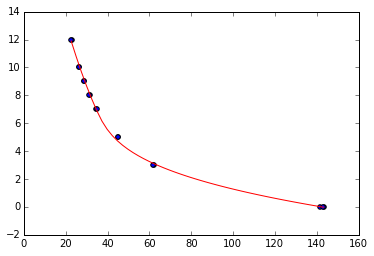

In [8]:
dred = np.linspace(np.min(calibration_red), np.max(calibration_red))

red_curve = create_inverse_spline(UnivariateSpline(calibration_dose, calibration_red))
plt.scatter(calibration_red, calibration_dose)
plt.plot(dred, red_curve(dred), 'r-')

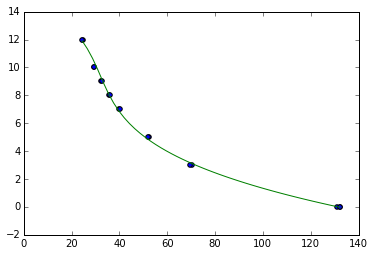

In [9]:
dgreen = np.linspace(np.min(calibration_green), np.max(calibration_green))

green_curve = create_inverse_spline(UnivariateSpline(calibration_dose, calibration_green))
plt.scatter(calibration_green, calibration_dose)
plt.plot(dgreen, green_curve(dgreen), 'g-')

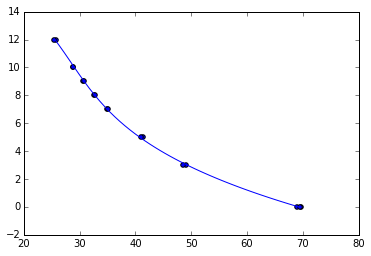

In [10]:
dblue = np.linspace(np.min(calibration_blue), np.max(calibration_blue))

blue_curve = create_inverse_spline(UnivariateSpline(calibration_dose, calibration_blue))
plt.scatter(calibration_blue, calibration_dose)
plt.plot(dblue, blue_curve(dblue), 'b-')

filepath = scans/treatment_A.png
    RED: min, mean, max predicted dose = 4.9, 6.3, 7.6 Gy
    GREEN: min, mean, max predicted dose = 5.0, 6.2, 7.2 Gy
    BLUE: min, mean, max predicted dose = 5.1, 6.3, 7.4 Gy



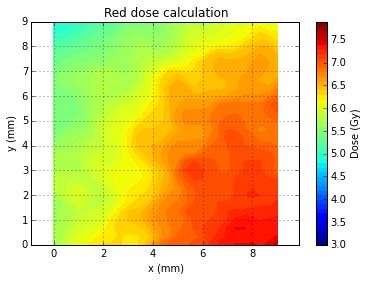

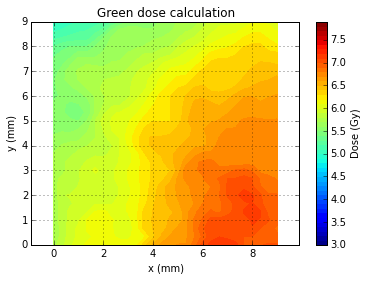

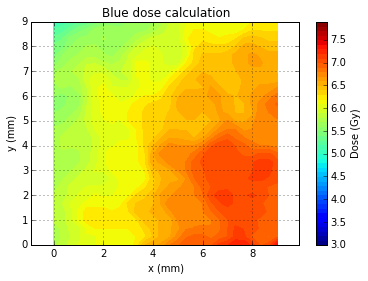

filepath = scans/treatment_B.png
    RED: min, mean, max predicted dose = 3.3, 5.0, 6.8 Gy
    GREEN: min, mean, max predicted dose = 3.4, 5.1, 6.7 Gy
    BLUE: min, mean, max predicted dose = 3.3, 5.1, 7.0 Gy



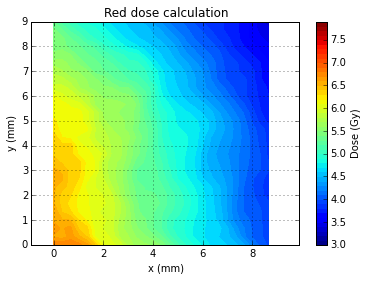

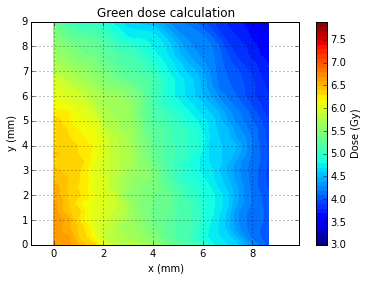

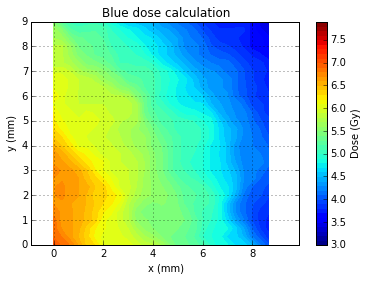

In [11]:
for i, scan_filepath in enumerate(treatment_list):    
    image = imread(scan_filepath)
    filtered_red = medfilt(wiener(image[:,:,0])[-1:1:-1,1:-1])[1:-1,1:-1]
    dose_red = red_curve(filtered_red)
    
    filtered_green = medfilt(wiener(image[:,:,1])[-1:1:-1,1:-1])[1:-1,1:-1]
    dose_green = green_curve(filtered_green)
    
    filtered_blue = medfilt(wiener(image[:,:,2])[-1:1:-1,1:-1])[1:-1,1:-1] 
    dose_blue = blue_curve(filtered_blue)
    
    max_red = np.max(dose_red)
    avg_red = np.mean(dose_red)
    min_red = np.min(dose_red)
    
    max_green = np.max(dose_green)
    avg_green = np.mean(dose_green)
    min_green = np.min(dose_green)
    
    max_blue = np.max(dose_blue)
    avg_blue = np.mean(dose_blue)
    min_blue = np.min(dose_blue)   
    
    print("filepath = %s" % (scan_filepath))
    print(
        "    RED: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" 
        % (min_red, avg_red, max_red)
    )
    print(
        "    GREEN: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" 
        % (min_green, avg_green, max_green )
    )
    
    print(
        "    BLUE: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" 
        % (min_blue, avg_blue, max_blue )
    )
    print()
    
    
    shape = np.shape(dose_red)
    x = np.arange(shape[1])/3
    y = np.arange(shape[0])/3
    
    xx, yy = np.meshgrid(x, y)
    
    levels = np.arange(3, 8, 0.1)
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_red, levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Red dose calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("Equal")
    plt.grid(True)
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_green, levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Green dose calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("Equal")
    plt.grid(True)
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_blue, levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Blue dose calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("Equal")
    plt.grid(True)
    
    plt.show()